# Regulator-burden correlation for lymphocyte count

## Gene-level correlation
First we will replicate Mineto's QQ-plot of regulator-burden correlations

In [1]:
import argparse
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
from tqdm import tqdm

In [25]:
def qq_signed_logp(pvals, effects, ax, label=None, genes=None, top_n=0, gene_set=None, gene_set_color=None, base_color=None):
    signed_logp = -np.log10(pvals) * np.sign(effects)
    order = np.argsort(signed_logp)
    obs   = signed_logp[order]
    n     = len(obs)
    q     = (np.arange(1, n+1) - 0.5) / n

    theor = np.empty(n)
    lower = q <= 0.5
    theor[lower]  =  np.log10(2 * q[lower])
    theor[~lower] = -np.log10(2 * (1 - q[~lower]))

    # Use base_color if provided, otherwise use default matplotlib colors
    scatter_color = base_color if base_color is not None else None
    
    # Plot regular points with matching base color
    ax.scatter(theor, obs, s=15, alpha=0.7, label=label, color=scatter_color)

    # Plot gene set points with different color
    if gene_set is not None and genes is not None:
        gene_set = set(gene_set)  # Convert to set for faster lookup
        
        # Find which genes in the gene set are present in our data
        gene_set_present = [gene for gene in gene_set if gene in genes]
        
        if gene_set_present:
            # Get indices of gene set genes in the original gene list
            gene_set_indices = [list(genes).index(gene) for gene in gene_set_present]
            
            # Map these to the sorted order
            gene_set_in_sorted = []
            for orig_idx in gene_set_indices:
                sorted_idx = np.where(order == orig_idx)[0][0]
                gene_set_in_sorted.append(sorted_idx)
            
            # Get the positions for gene set genes
            gene_set_theor = theor[gene_set_in_sorted]
            gene_set_obs = obs[gene_set_in_sorted]
            
            # Plot gene set points with different color and larger size
            ax.scatter(gene_set_theor, gene_set_obs, s=50, alpha=0.8, 
                      color=gene_set_color, edgecolors='black', linewidth=1, 
                      label=f'{label}_gene_set' if label else 'gene_set')

    # Return top genes as a list instead of plotting them
    top_genes_list = []
    if genes is not None and top_n > 0:
        # Get top_n genes by signed_logp (highest positive values only)
        top_idxs = np.argsort(np.abs(signed_logp))[-top_n:]
        top_genes_list = [(genes[idx], signed_logp[idx], pvals[idx], effects[idx]) for idx in top_idxs]

    return ax, top_genes_list

### Specify conditions

In [27]:
trait = "LymphocyteCount"
conds    = ["K562", "HepG2", "Jurkat", "RPE1", "Rest", "Stim8hr", "Stim48hr"]
cond_files = {
    "K562": f"/mnt/oak/users/mineto/workstation/K562_revise/BurdenRegCor/GeneLevel_v2/K562GW/Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt",

    "HepG2": f"/mnt/oak/users/mineto/workstation/K562_revise/BurdenRegCor/GeneLevel_v2/GSE264667_hepg2_raw_singlecell_01/Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt",

    "Jurkat": f"/mnt/oak/users/mineto/workstation/K562_revise/BurdenRegCor/GeneLevel_v2/GSE264667_jurkat_raw_singlecell_01/Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt",
    
    "RPE1": f"/mnt/oak/users/mineto/workstation/K562_revise/BurdenRegCor/GeneLevel_v2/rpe1_raw_singlecell_01/Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt",

    "Rest": f"/mnt/oak/users/mineto/workstation/250717_TcellPerturb/BurdenRegCor/GeneLevel/Rest_Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt",

    "Stim8hr": f"/mnt/oak/users/mineto/workstation/250717_TcellPerturb/BurdenRegCor/GeneLevel/Stim8hr_Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt", 

    "Stim48hr": f"/mnt/oak/users/mineto/workstation/250717_TcellPerturb/BurdenRegCor/GeneLevel/Stim48hr_Backman_{trait}_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt"
}

base_color_map = {
    "K562": "lightgray",
    "HepG2": "darkgray", 
    "Jurkat": "gray",
    "RPE1": "black",
    "Rest": "lightgreen",     
    "Stim8hr": "mediumseagreen",     
    "Stim48hr": "green"
}

gene_set_color_map = {
    "K562": "gainsboro",
    "HepG2": "dimgray",     
    "Jurkat": "gray",
    "RPE1": "black",
    "Rest": "forestgreen",
    "Stim8hr": "darkgreen",     
    "Stim48hr": "darkgreen"
}

In [28]:
# How many genes are there in each condition?
gene_counts = {}

for cond in conds:
    try:
        df = pd.read_csv(cond_files[cond], sep="\t")
        gene_counts[cond] = len(df)
        print(f"{cond}: {len(df)} genes")
    except FileNotFoundError:
        gene_counts[cond] = 0
        print(f"{cond}: File not found")
    except Exception as e:
        gene_counts[cond] = 0
        print(f"{cond}: Error - {e}")

# Create a nice formatted table
count_df = pd.DataFrame(list(gene_counts.items()), columns=['Condition', 'Gene Count'])
print("\nGene Count Summary:")
print(count_df.to_string(index=False))

K562: 8248 genes
HepG2: 9624 genes
Jurkat: 8882 genes
RPE1: 8749 genes
Rest: 12538 genes
Stim8hr: 12558 genes
Stim48hr: 12859 genes

Gene Count Summary:
Condition  Gene Count
     K562        8248
    HepG2        9624
   Jurkat        8882
     RPE1        8749
     Rest       12538
  Stim8hr       12558
 Stim48hr       12859


### Plot QQ plot for burden-regulator correlation across genes

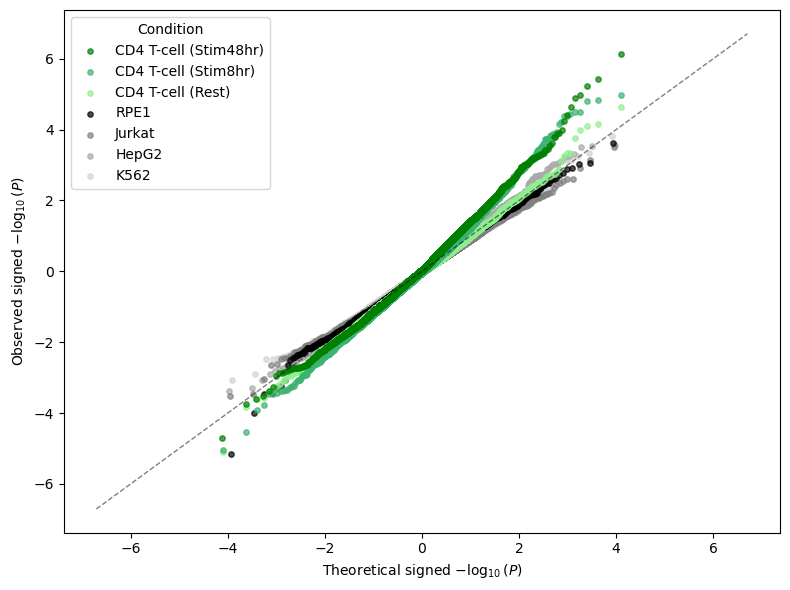

In [29]:
# First using Mineto's regression results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for cond in conds:
    fn = cond_files[cond]
    df = pd.read_csv(fn, sep="\t")
    
    ax, top_genes = qq_signed_logp(
        df["P_withShet"].values,
        df["beta_withShet"].values,
        ax,
        label=cond,
        genes=df["gene"].values,
        top_n=0,  # No top genes
        gene_set=None,  # No gene set
        gene_set_color=None,
        base_color=base_color_map[cond]  
    )

# Format the plot
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]),
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

ax.plot([-lim, lim], [-lim, lim], color="black", lw=1, linestyle='--', alpha=0.5)
ax.set_xlabel("Theoretical signed $-\\log_{10}(P)$")
ax.set_ylabel("Observed signed $-\\log_{10}(P)$")
# ax.set_title("QQ‐plot of signed $-\\log_{10}(P)$ by condition")

custom_labels = []
for cond in conds:
    if cond.startswith("Stim") or cond.startswith("Rest"):
        custom_labels.append(f"CD4 T-cell ({cond})")
    else:
        custom_labels.append(cond)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], custom_labels[::-1], title="Condition")

plt.tight_layout()
plt.show()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


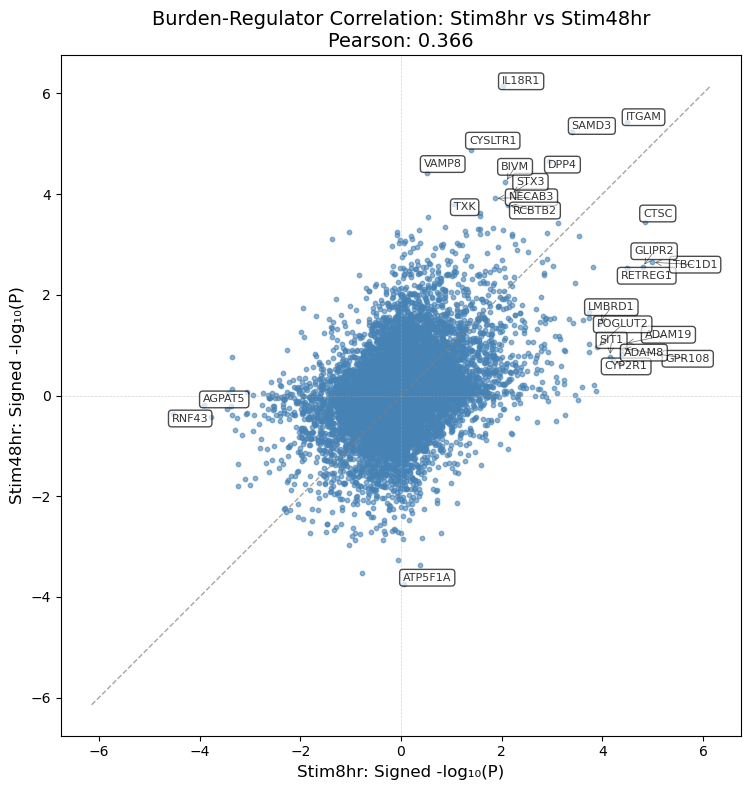

Correlation between Stim8hr and Stim48hr: 0.366
Number of common genes: 12035

Top genes by absolute signed log p-value:
Stim8hr: ['POGLUT2', 'AGPAT5', 'LMBRD1', 'SIT1', 'CYP2R1', 'GPR108', 'ADAM8', 'ADAM19', 'ITGAM', 'RETREG1']
Stim48hr: ['ATP5F1A', 'RCBTB2', 'TXK', 'SLC6A1', 'NECAB3', 'STX3', 'BIVM', 'VAMP8', 'DPP4', 'SLC13A2']


In [30]:
# Scatterplot of Stim8hr vs Stim48hr burden-regulator correlations
from adjustText import adjust_text

# Create scatterplot for Stim8hr vs Stim48hr signed log p-values
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Get data for both conditions
stim8hr_data = pd.read_csv(cond_files["Stim8hr"], sep="\t")
stim48hr_data = pd.read_csv(cond_files["Stim48hr"], sep="\t")

# Calculate signed log p-values
stim8hr_signed_logp = -np.log10(stim8hr_data["P_withShet"].values) * np.sign(stim8hr_data["beta_withShet"].values)
stim48hr_signed_logp = -np.log10(stim48hr_data["P_withShet"].values) * np.sign(stim48hr_data["beta_withShet"].values)

# Get gene names
stim8hr_genes = stim8hr_data["gene"].values
stim48hr_genes = stim48hr_data["gene"].values

# Find common genes
common_genes = set(stim8hr_genes) & set(stim48hr_genes)

# Create mapping for common genes
stim8hr_dict = dict(zip(stim8hr_genes, stim8hr_signed_logp))
stim48hr_dict = dict(zip(stim48hr_genes, stim48hr_signed_logp))

# Get values for common genes
x_vals = [stim8hr_dict[gene] for gene in common_genes]
y_vals = [stim48hr_dict[gene] for gene in common_genes]

# Create scatter plot
ax.scatter(x_vals, y_vals, alpha=0.6, s=10, color='steelblue')

# Add diagonal line
max_val = max(abs(min(x_vals)), abs(max(x_vals)), abs(min(y_vals)), abs(max(y_vals)))
ax.plot([-max_val, max_val], [-max_val, max_val], '--', color='gray', alpha=0.7, linewidth=1)

# Add zero lines
ax.axhline(y=0, color='darkgrey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.axvline(x=0, color='darkgrey', linestyle='--', alpha=0.5, linewidth=0.5)

# Label top genes by absolute signed log p-value
def get_top_genes_by_abs_signed_logp(condition, n_top=10):
    """Get top n_top genes by absolute signed log p-value."""
    fn = cond_files[condition]
    df = pd.read_csv(fn, sep="\t")
    signed_logp = -np.log10(df["P_withShet"].values) * np.sign(df["beta_withShet"].values)
    top_idx = np.argsort(np.abs(signed_logp))[-n_top:]
    return df["gene"].values[top_idx], signed_logp[top_idx]

# Get top genes for both conditions
stim8hr_top_genes, stim8hr_top_scores = get_top_genes_by_abs_signed_logp("Stim8hr", n_top=15)
stim48hr_top_genes, stim48hr_top_scores = get_top_genes_by_abs_signed_logp("Stim48hr", n_top=15)

# Combine and get unique top genes
all_top_genes = list(set(list(stim8hr_top_genes) + list(stim48hr_top_genes)))

# Collect text objects for adjustment
texts = []

# Label top genes on the plot
for gene in all_top_genes:
    if gene in common_genes:
        x_pos = stim8hr_dict[gene]
        y_pos = stim48hr_dict[gene]
        
        # Only label if it's a significant gene in either condition
        if abs(x_pos) > 3 or abs(y_pos) > 3:  # Threshold for labeling
            text = ax.annotate(gene, (x_pos, y_pos), 
                              fontsize=8, alpha=0.8,
                              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
            texts.append(text)

# Adjust text positions to avoid overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.6, lw=0.5),
           expand_points=(1.5, 1.5),
           force_points=(0.1, 0.1))

# Calculate correlation
correlation = np.corrcoef(x_vals, y_vals)[0, 1]

# Format the plot
ax.set_xlabel("Stim8hr: Signed -log₁₀(P)", fontsize=12)
ax.set_ylabel("Stim48hr: Signed -log₁₀(P)", fontsize=12)
ax.set_title(f"Burden-Regulator Correlation: Stim8hr vs Stim48hr\nPearson: {correlation:.3f}", fontsize=14)

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Print summary of top genes
print(f"Correlation between Stim8hr and Stim48hr: {correlation:.3f}")
print(f"Number of common genes: {len(common_genes)}")
print(f"\nTop genes by absolute signed log p-value:")
print("Stim8hr:", stim8hr_top_genes[:10].tolist())
print("Stim48hr:", stim48hr_top_genes[:10].tolist())

In [31]:
def get_top_genes_by_signed_logp(condition, n_top=100):
    """Get top n_top positive and negative genes by signed log10P for a given condition."""
    if condition not in cond_files:
        raise ValueError(f"Condition {condition} not found in cond_files")
    
    # Load data for the condition
    fn = cond_files[condition]
    df = pd.read_csv(fn, sep="\t")
    
    # Calculate signed log p-values
    signed_logp = -np.log10(df["P_withShet"].values) * np.sign(df["beta_withShet"].values)
    
    # Get top positive genes (highest positive signed_logp)
    top_positive_idx = np.argsort(signed_logp)[-n_top:][::-1]
    top_positive_genes = df["gene"].values[top_positive_idx].tolist()
    
    # Get top negative genes (lowest negative signed_logp)
    top_negative_idx = np.argsort(signed_logp)[:n_top]
    top_negative_genes = df["gene"].values[top_negative_idx].tolist()
    
    return {
        'positive': top_positive_genes,
        'negative': top_negative_genes,
        'positive_scores': signed_logp[top_positive_idx].tolist(),
        'negative_scores': signed_logp[top_negative_idx].tolist()
    }

In [32]:
for cond in ["Stim8hr", "Stim48hr"]:
    for direction in ["positive", "negative"]:
        top_genes = get_top_genes_by_signed_logp(cond, n_top=20)[direction]
        print(f"{cond} {direction} top genes: {top_genes}")

Stim8hr positive top genes: ['TBC1D1', 'CTSC', 'GLIPR2', 'RETREG1', 'ITGAM', 'ADAM19', 'ADAM8', 'GPR108', 'CYP2R1', 'SIT1', 'LMBRD1', 'POGLUT2', 'CAMK2G', 'SNX10', 'CAPZA1', 'CCDC88B', 'PXN', 'S100A10', 'RBMS1', 'SLC39A8']
Stim8hr negative top genes: ['IMP3', 'RNF43', 'AGPAT5', 'ZNF492', 'GUCY1A2', 'MBD2', 'CLNK', 'TERT', 'RCC1L', 'ZNF488', 'SSTR1', 'C19orf38', 'CCN1', 'XPO5', 'LYL1', 'FARP2', 'SRM', 'COMMD10', 'TRAK1', 'H1-0']
Stim48hr positive top genes: ['IL18R1', 'ITGAM', 'SAMD3', 'FAM237A', 'CYSLTR1', 'DPP4', 'VAMP8', 'BIVM', 'STX3', 'NECAB3', 'SLC6A1', 'TXK', 'RCBTB2', 'MACROH2A1', 'NCF4', 'CDKN2C', 'A2M', 'CTSC', 'CD47', 'MYD88']
Stim48hr negative top genes: ['SLC13A2', 'ATP5F1A', 'SERP2', 'SLC25A4', 'PAFAH1B1', 'SFT2D1', 'HPDL', 'BOLA3', 'NDUFAB1', 'PDCD10', 'NDST1', 'MTERF4', 'PRPSAP2', 'UQCRHL', 'YWHAQ', 'ULBP1', 'TOX2', 'ENSA', 'MGLL', 'SUB1']



=== Analyzing Stim8hr ===
Performing GO annotation for positive genes...
Found 36 significant terms for positive genes
Performing GO annotation for negative genes...
No significant GO terms found for Stim8hr negative

=== Analyzing Stim48hr ===
Performing GO annotation for positive genes...
Found 59 significant terms for positive genes
Performing GO annotation for negative genes...
Found 1 significant terms for negative genes

Total significant terms: 96

=== Creating dotplot for Stim8hr positive ===


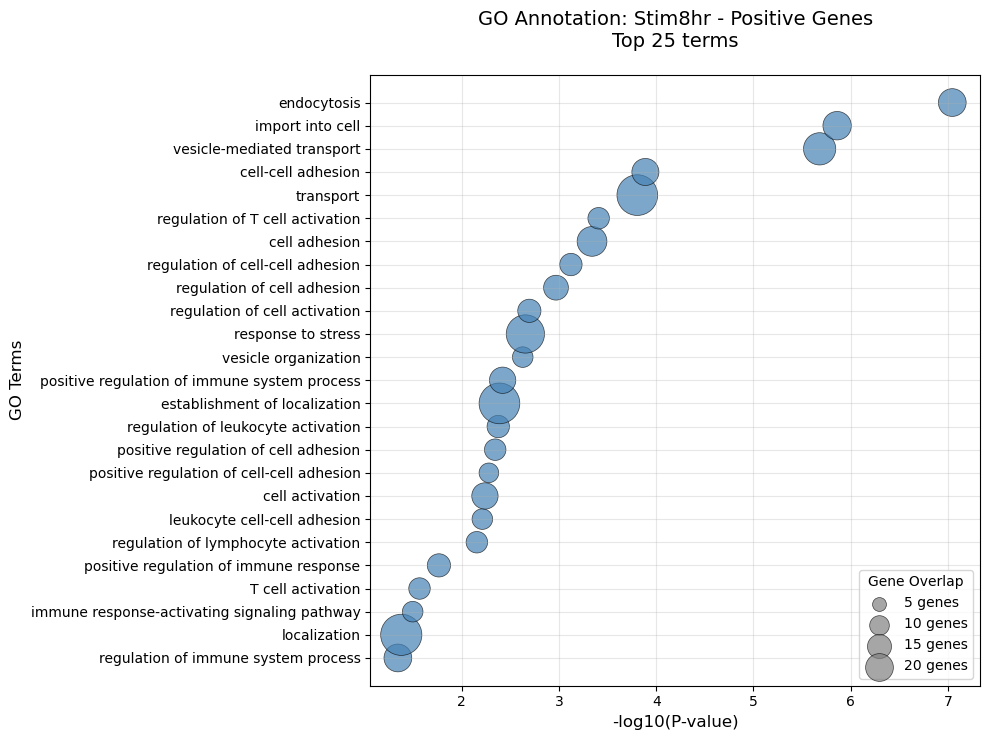


Stim8hr Positive - Top terms by significance:
  regulation of immune system process: -log10(P)=1.34, overlap=20 genes
  localization: -log10(P)=1.38, overlap=44 genes
  immune response-activating signaling pathway: -log10(P)=1.49, overlap=11 genes
  T cell activation: -log10(P)=1.56, overlap=12 genes
  positive regulation of immune response: -log10(P)=1.76, overlap=14 genes
  regulation of lymphocyte activation: -log10(P)=2.15, overlap=12 genes
  leukocyte cell-cell adhesion: -log10(P)=2.21, overlap=11 genes
  cell activation: -log10(P)=2.24, overlap=18 genes
  positive regulation of cell-cell adhesion: -log10(P)=2.28, overlap=10 genes
  positive regulation of cell adhesion: -log10(P)=2.34, overlap=12 genes

=== Creating dotplot for Stim8hr negative ===
No significant terms found for Stim8hr negative

=== Creating dotplot for Stim48hr positive ===


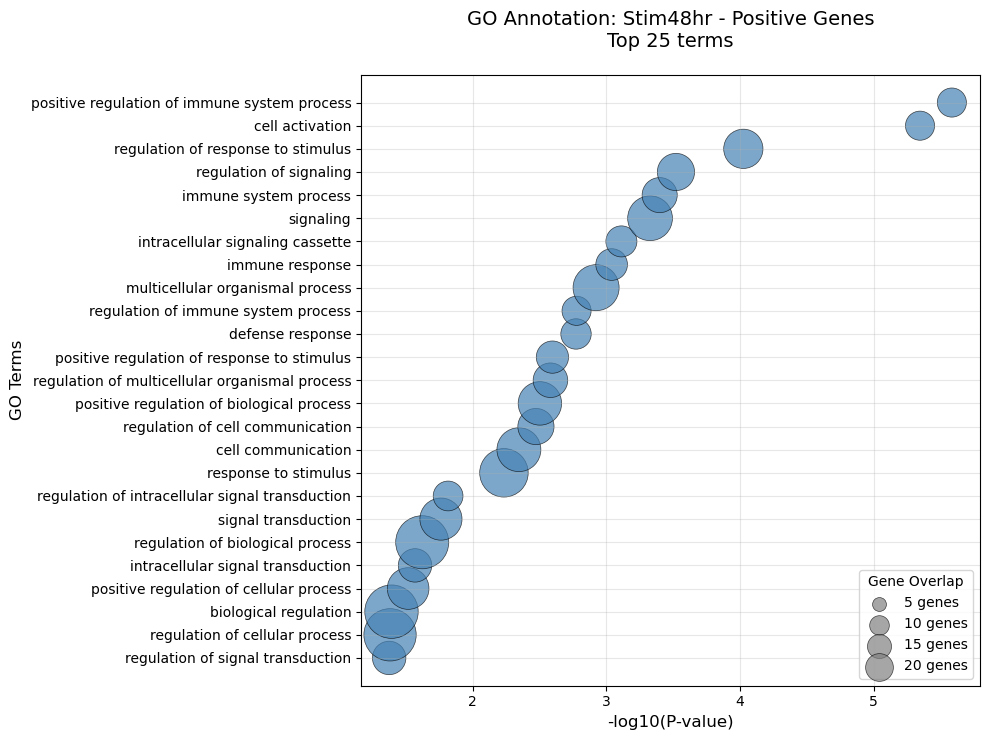


Stim48hr Positive - Top terms by significance:
  regulation of signal transduction: -log10(P)=1.37, overlap=29 genes
  regulation of cellular process: -log10(P)=1.38, overlap=71 genes
  biological regulation: -log10(P)=1.39, overlap=74 genes
  positive regulation of cellular process: -log10(P)=1.52, overlap=45 genes
  intracellular signal transduction: -log10(P)=1.57, overlap=29 genes
  regulation of biological process: -log10(P)=1.62, overlap=73 genes
  signal transduction: -log10(P)=1.76, overlap=46 genes
  regulation of intracellular signal transduction: -log10(P)=1.82, overlap=23 genes
  response to stimulus: -log10(P)=2.23, overlap=61 genes
  cell communication: -log10(P)=2.35, overlap=50 genes

=== Creating dotplot for Stim48hr negative ===


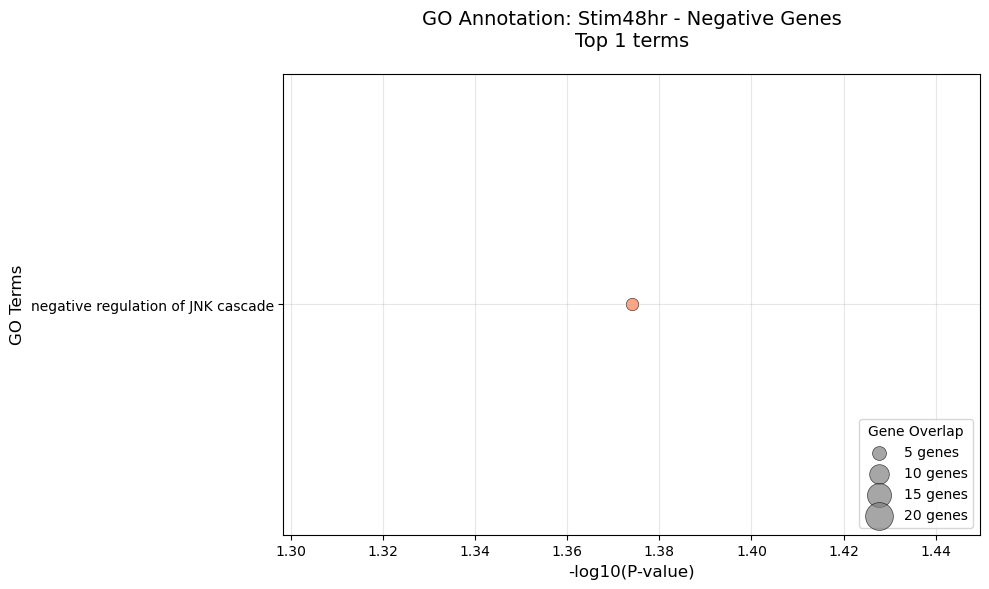


Stim48hr Negative - Top terms by significance:
  negative regulation of JNK cascade: -log10(P)=1.37, overlap=4 genes

=== Summary by Source ===
        count   p_value  precision
source                            
GO:BP      96  0.013153    0.22956

=== Top Terms by Significance ===
                                                              name source condition direction      p_value  precision
                                                       endocytosis  GO:BP   Stim8hr  positive 8.999328e-08   0.212766
                                                  import into cell  GO:BP   Stim8hr  positive 1.376795e-06   0.223404
                                              leukocyte activation  GO:BP  Stim48hr  positive 1.983384e-06   0.230769
                                        vesicle-mediated transport  GO:BP   Stim8hr  positive 2.085372e-06   0.287234
                      positive regulation of immune system process  GO:BP  Stim48hr  positive 2.593549e-06   0.241758
       

In [33]:
## Comprehensive GO Annotation Analysis with Separate Dotplots
import gprofiler
import matplotlib.pyplot as plt
import seaborn as sns

# How many genes to analyze for GO annotation
n_top_genes = 100

def perform_go_annotation(gene_list, condition, direction, organism="hsapiens"):
    """
    Perform GO annotation using gprofiler-official.
    
    Args:
        gene_list: List of gene symbols
        condition: String, condition name
        direction: String, "positive" or "negative"
        organism: String, organism code (default: "hsapiens")
    
    Returns:
        DataFrame: GO annotation results
    """
    try:
        # Create GProfiler instance and perform analysis
        gp = gprofiler.GProfiler(return_dataframe=True)
        result = gp.profile(
            organism=organism,
            query=gene_list,
            sources=['GO:BP'],  # Biological Process, Molecular Function, Cellular Component
            significance_threshold_method='g_SCS',
            user_threshold=0.05
        )
        
        # Add metadata columns
        if result is not None and len(result) > 0:
            result['condition'] = condition
            result['direction'] = direction
            return result
        else:
            print(f"No significant GO terms found for {condition} {direction}")
            return None
            
    except Exception as e:
        print(f"Error in GO annotation for {condition} {direction}: {e}")
        return None

def create_separate_go_dotplots(combined_results, conditions_to_analyze, top_n=25):
    """Create separate dotplots for each condition and direction."""
    
    # Filter for most significant terms across all conditions
    significant_terms = combined_results[combined_results['p_value'] < 0.05].copy()
    
    # Create separate plots for each condition and direction
    for condition in conditions_to_analyze:
        for direction in ['positive', 'negative']:
            print(f"\n=== Creating dotplot for {condition} {direction} ===")
            
            # Filter data for this specific condition and direction
            subset = significant_terms[
                (significant_terms['condition'] == condition) & 
                (significant_terms['direction'] == direction)
            ]
            
            if len(subset) == 0:
                print(f"No significant terms found for {condition} {direction}")
                continue
            
            # Get top terms by significance for this condition/direction
            top_terms = subset.nlargest(top_n, 'precision')
            
            if len(top_terms) == 0:
                print(f"No terms to plot for {condition} {direction}")
                continue
            
            # Create the plot
            plt.figure(figsize=(10, max(6, len(top_terms) * 0.3)))  # Adjust height based on number of terms
            
            # Sort terms by significance (most significant at top)
            top_terms = top_terms.sort_values('p_value', ascending=False)
            
            # Create scatter plot
            plt.scatter(
                -np.log10(top_terms['p_value']), 
                top_terms['name'],
                s=top_terms['intersection_size'] * 20,  # Size by intersection size
                alpha=0.7,
                color='steelblue' if direction == 'positive' else 'coral',
                edgecolors='black',
                linewidth=0.5
            )
            
            # Format the plot
            plt.xlabel('-log10(P-value)', fontsize=12)
            plt.ylabel('GO Terms', fontsize=12)
            plt.title(f'GO Annotation: {condition} - {direction.capitalize()} Genes\nTop {len(top_terms)} terms', fontsize=14, pad=20)
            
            # Create legend for bubble sizes
            legend_elements = []
            sizes = [5, 10, 15, 20]  # Example intersection sizes
            for size in sizes:
                legend_elements.append(plt.scatter([], [], s=size*20, c='gray', alpha=0.7, 
                                                edgecolors='black', linewidth=0.5, 
                                                label=f'{size} genes'))
            
            plt.legend(handles=legend_elements, title="Gene Overlap", loc='lower right')
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Print summary for this condition/direction
            print(f"\n{condition} {direction.capitalize()} - Top terms by significance:")
            for _, row in top_terms.head(10).iterrows():
                print(f"  {row['name']}: -log10(P)={-np.log10(row['p_value']):.2f}, overlap={row['intersection_size']} genes")

# Perform comprehensive GO annotation
conditions_to_analyze = ["Stim8hr", "Stim48hr"]
all_results = []

for condition in conditions_to_analyze:
    print(f"\n=== Analyzing {condition} ===")
    
    # Get top genes
    top_genes = get_top_genes_by_signed_logp(condition, n_top=n_top_genes)
    
    # Perform GO annotation for positive genes
    print(f"Performing GO annotation for positive genes...")
    pos_go = perform_go_annotation(top_genes['positive'], condition, "positive")
    if pos_go is not None:
        all_results.append(pos_go)
        print(f"Found {len(pos_go)} significant terms for positive genes")
    
    # Perform GO annotation for negative genes
    print(f"Performing GO annotation for negative genes...")
    neg_go = perform_go_annotation(top_genes['negative'], condition, "negative")
    if neg_go is not None:
        all_results.append(neg_go)
        print(f"Found {len(neg_go)} significant terms for negative genes")

# Create separate dotplots
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal significant terms: {len(combined_results)}")
    
    # Create separate dotplots for each condition and direction
    create_separate_go_dotplots(combined_results, conditions_to_analyze, top_n=25)
    
    # Summary statistics
    print("\n=== Summary by Source ===")
    source_summary = combined_results.groupby('source').agg({
        'name': 'count',
        'p_value': 'mean',
        'precision': 'mean'
    }).rename(columns={'name': 'count'})
    print(source_summary)
    
    print("\n=== Top Terms by Significance ===")
    top_terms = combined_results.nsmallest(20, 'p_value')[['name', 'source', 'condition', 'direction', 'p_value', 'precision']]
    print(top_terms.to_string(index=False))

else:
    print("No GO annotation results to display.")

### Does combining conditions improve signal of burden-regulator correlation?
In the original QQ plot: regress Burden effect ~ Regulator effect + shet, and QQ-plot the P-value of the regulator effect coefficient.


For 2 conditions: regress Burden effect ~ Regulator effect of cond1 + Regulator effect of cond2 + shet. 

The coefficient is obtained by

$$
\hat\beta = \hat\beta_1 + \hat\beta_2,
$$

and the variance of the sum of effects is given by

$$
\operatorname{Var}(\hat\beta_1+\hat\beta_2)
= \operatorname{Var}(\hat\beta_1)
	+	\operatorname{Var}(\hat\beta_2)
	+	2\operatorname{Cov}(\hat\beta_1,\hat\beta_2).
$$

The P-value is obtained from the t-statistic 
$$
t=\frac{\hat\beta_1+\hat\beta_2}{\mathrm{SE}(\hat\beta_1+\hat\beta_2)}.
$$

In [34]:
import os
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import anndata as ad
from scipy import sparse as sp
from tqdm.auto import tqdm  # pretty in notebooks; falls back in terminals

# ---- config (set these) ------------------------------------------------------
burden_file  = "/mnt/oak/users/mineto/workstation/250717_TcellPerturb/input/burden/Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv"
de_file      = "/mnt/oak/users/emma/data/GWT/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad"
corresp_file = "/mnt/oak/users/mineto/workstation/GRN/gencode_v41_gname_gid_ALL_sorted_onlyID"
shet_file    = "/mnt/oak/users/mineto/workstation/250717_TcellPerturb/shet_10bins.txt"   # adjust if needed

out_dir      = "/mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr"
!mkdir -p $out_dir
min_targets  = 100  # require >100 targets to run a regression

In [35]:
def zscore_series(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce")
    mu = x.mean()
    sd = x.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return None
    return (x - mu) / sd

def load_corresp(path):
    # Expect two columns (no header): ENSG  SYMBOL
    c = pd.read_csv(path, sep=r"\s+|\t|,", header=None, engine="python")
    if c.shape[1] < 2:
        raise ValueError("corresp_file must have at least two columns: [ENSG, SYMBOL]")
    c = c.iloc[:, :2].copy()
    c.columns = ["ensg", "symbol"]
    # mimic R: unique by each column
    c = c.drop_duplicates(subset=["ensg"])
    c = c.drop_duplicates(subset=["symbol"])
    ensg2sym = dict(zip(c["ensg"], c["symbol"]))
    sym2ensg = dict(zip(c["symbol"], c["ensg"]))
    return ensg2sym, sym2ensg

def load_lof(path):
    lof = pd.read_csv(path, sep="\t", header=0)
    # try to find 'ensg'
    if "ensg" not in lof.columns:
        cand = [c for c in lof.columns if "ensg" in c.lower() or "ensembl" in c.lower()]
        if not cand:
            raise ValueError("Could not find an 'ensg' column in LOF file.")
        lof = lof.rename(columns={cand[0]: "ensg"})
    if "post_mean" not in lof.columns:
        raise ValueError("LOF file must contain 'post_mean'.")
    pm = pd.to_numeric(lof["post_mean"], errors="coerce")
    finite_mask = np.isfinite(pm)
    if finite_mask.any():
        pm = pm.copy()
        # clamp ±Inf as in your R
        pm[(~finite_mask) & (lof["post_mean"] > 0)] = pm[finite_mask].max()
        pm[(~finite_mask) & (lof["post_mean"] < 0)] = pm[finite_mask].min()
        # if any NaN remain, drop them
    lof["post_mean"] = pm
    lof = lof[["ensg", "post_mean"]].dropna()
    return lof

def load_shet(path, keep_ensg=None):
    if not os.path.exists(path):
        warnings.warn(f"shet file not found at '{path}'. Regressions will omit 'shet'.")
        return None
    s = pd.read_csv(path, sep="\t")
    if "ensg" not in s.columns:
        cand = [c for c in s.columns if "ensg" in c.lower() or "ensembl" in c.lower()]
        if not cand:
            raise ValueError("Could not find 'ensg' in shet file.")
        s = s.rename(columns={cand[0]: "ensg"})
    if "shet" not in s.columns:
        cand = [c for c in s.columns if "shet" in c.lower()]
        if not cand:
            raise ValueError("Could not find 'shet' column in shet file.")
        s = s.rename(columns={cand[0]: "shet"})
    s = s[["ensg", "shet"]].dropna()
    if keep_ensg is not None:
        s = s[s["ensg"].isin(keep_ensg)]
    return s

def load_de_h5ad(path):
    adata = ad.read_h5ad(path)
    meta_cols = {"culture_condition", "target_contrast_gene_name"}

    if meta_cols.issubset(set(adata.var.columns)):
        # contrasts in .var (columns of X)
        meta = adata.var.loc[:, list(meta_cols)].copy()
        X = adata.layers['log_fc']
        if sp.issparse(X):
            X = X.toarray()
        betas = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)  # rows=genes, cols=contrasts
    elif meta_cols.issubset(set(adata.obs.columns)):
        # contrasts in .obs (rows of X) -> transpose
        meta = adata.obs.loc[:, list(meta_cols)].copy()
        X = adata.layers['log_fc']
        if sp.issparse(X):
            X = X.toarray()
        betas = pd.DataFrame(X.T, index=adata.var_names, columns=adata.obs_names)  # rows=genes, cols=contrasts
    else:
        raise ValueError("Could not find 'culture_condition' and 'target_contrast_gene_name' in .var or .obs.")

    # collapse duplicate gene rows by mean
    if betas.index.duplicated().any():
        betas = betas.groupby(betas.index).mean()

    meta.index.name = "contrast_id"
    return betas, meta

def condition_matrix(betas: pd.DataFrame, meta: pd.DataFrame, condition: str) -> pd.DataFrame:
    """Return matrix with index = response gene (ENSG or symbol), columns = target SYMBOLs."""
    sel = meta["culture_condition"] == condition
    if not sel.any():
        raise ValueError(f"No contrasts found for condition '{condition}'.")
    cols = meta.index[sel]
    sub = betas.loc[:, cols].copy()
    # rename columns to target symbols
    target_syms = meta.loc[cols, "target_contrast_gene_name"].astype(str).values
    sub.columns = target_syms
    # aggregate duplicate targets (replicates) by mean
    if sub.columns.duplicated().any():
        sub = sub.groupby(level=0, axis=1).mean()
    return sub

def build_pair_design(dfA: pd.DataFrame, dfB: pd.DataFrame):
    common_targets = sorted(set(dfA.columns).intersection(dfB.columns))
    A2 = dfA.loc[:, common_targets]
    B2 = dfB.loc[:, common_targets]
    return A2, B2

# def contrast_signed(res, weights):
#     """Linear contrast t-test. weights = {'term': weight, ...}"""
#     names = list(res.params.index)
#     c = np.zeros(len(names))
#     for k, w in weights.items():
#         if k not in names:
#             return np.nan, np.nan, np.nan
#         c[names.index(k)] = w
#     theta = float(c @ res.params.values)
#     V = res.cov_params().values
#     se = float(np.sqrt(c @ V @ c))
#     if not np.isfinite(se) or se == 0:
#         return np.nan, np.nan, np.nan
#     t = theta / se
#     p = 2 * stats.t.sf(abs(t), df=int(res.df_resid))
#     signed_log10p = np.sign(theta) * (-np.log10(p))
#     return theta, p, signed_log10p

In [36]:
betas, meta = load_de_h5ad(de_file)
ensg2sym, sym2ensg = load_corresp(corresp_file)
lof = load_lof(burden_file)
print(f"betas.head(): {betas.head()}")
print(f"meta.head(): {meta.head()}")
print(f"lof.head(): {lof.head()}")

betas.head():                  ENSG00000012963_Stim8hr  ENSG00000017260_Stim8hr  \
ENSG00000000003                -0.098318                 0.074605   
ENSG00000000419                 0.002781                -0.045409   
ENSG00000000457                -0.033949                -0.089124   
ENSG00000000460                -0.110018                -0.144538   
ENSG00000000938                -0.370177                -0.262115   

                 ENSG00000067606_Stim8hr  ENSG00000092929_Stim8hr  \
ENSG00000000003                -0.031044                -0.029345   
ENSG00000000419                -0.086508                 0.007460   
ENSG00000000457                 0.024340                 0.051432   
ENSG00000000460                -0.064186                 0.049329   
ENSG00000000938                 0.574737                -0.562878   

                 ENSG00000100504_Stim8hr  ENSG00000102901_Stim8hr  \
ENSG00000000003                -0.182187                 0.121810   
ENSG00000000419   

In [37]:
# ensure betas.index are ENSG; if symbols, map to ENSG
if not pd.Index(betas.index).astype(str).str.startswith("ENSG").all():
    mapped = pd.Index(betas.index).to_series().map(sym2ensg)
    ok = mapped.notna()
    betas = betas.loc[ok, :]
    betas.index = mapped[ok].values

# optional: keep only genes present in LOF to reduce work
keep = betas.index.intersection(lof["ensg"].unique())
if len(keep) > 0:
    betas = betas.loc[keep, :]

shet = load_shet(shet_file, keep_ensg=set(lof["ensg"]))
os.makedirs(out_dir, exist_ok=True)

conditions_single = ["Rest", "Stim8hr", "Stim48hr"]
conditions_pair   = [("Stim8hr", "Stim48hr"),
                     ("Rest", "Stim8hr"),
                     ("Rest", "Stim48hr")]

cond_mats = {c: condition_matrix(betas, meta, c) for c in conditions_single}
from collections import Counter

single_outputs = {}
base = os.path.basename(burden_file)
for cond in tqdm(conditions_single, desc="Single-condition sets", leave=False):
    out_path = os.path.join(out_dir, f"{cond}_{base}_geneRegulation_correlation.txt")
    if os.path.exists(out_path):
        out = pd.read_csv(out_path, sep="\t")
        single_outputs[cond] = out
        print(f"[{cond}] loaded {len(out)} models from {out_path}")
        continue

    df_cond = cond_mats[cond]
    rows = []
    skip = Counter()

    for resp_ensg in tqdm(df_cond.index, desc=f"{cond}: genes", leave=False):
        tmp = pd.DataFrame({
            "target_symbol": df_cond.columns,
            "perturb_beta": df_cond.loc[resp_ensg, :].values
        })
        tmp["ensg"] = tmp["target_symbol"].map(sym2ensg)
        tmp = tmp.dropna(subset=["ensg"])
        tmp = tmp[tmp["ensg"] != resp_ensg]

        df2 = tmp.merge(lof, on="ensg", how="inner")
        if shet is not None:
            df2 = df2.merge(shet, on="ensg", how="inner")

        if df2.shape[0] <= min_targets:
            skip["too_few_targets"] += 1
            continue

        y = pd.to_numeric(df2["post_mean"], errors="coerce")
        x1 = zscore_series(df2["perturb_beta"])
        y_z = zscore_series(y)

        if x1 is None or y_z is None:
            skip["constant_or_nan_predictor"] += 1
            continue

        X = pd.DataFrame({"perturb_beta": x1})
        if shet is not None and "shet" in df2:
            X["shet"] = pd.to_numeric(df2["shet"], errors="coerce")

        X = sm.add_constant(X, has_constant="add")
        try:
            res = sm.OLS(y_z, X, missing="drop").fit()
        except Exception:
            skip["model_fit_error"] += 1
            continue

        beta = float(res.params.get("perturb_beta", np.nan))
        p_beta = float(res.pvalues.get("perturb_beta", np.nan))
        rows.append({
            "gene": ensg2sym.get(resp_ensg, resp_ensg),
            "ensg": resp_ensg,
            "n": int(res.nobs),
            "k": int(X.shape[1] - 1),
            "R2": float(res.rsquared) if res.rsquared is not None else np.nan,
            "beta": beta,
            "p_beta": p_beta
        })

    out = pd.DataFrame(rows)
    if out.empty:
        out = pd.DataFrame(columns=["gene", "ensg", "n", "k", "R2", "beta", "p_beta"])
        print(f"[{cond}] no models met criteria. Skips: {dict(skip)}")
    else:
        out = out.sort_values(by="p_beta", na_position="last").reset_index(drop=True)
        print(f"[{cond}] fitted {len(out)} models. Skips: {dict(skip)}")

    single_outputs[cond] = out
    out.to_csv(out_path, sep="\t", index=False)
    print(f"[{cond}] saved {len(out)} models to {out_path}")

Single-condition sets:   0%|          | 0/3 [00:00<?, ?it/s]

[Rest] loaded 12455 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Rest_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Stim8hr] loaded 12497 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Stim8hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Stim48hr] loaded 12739 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt


In [38]:
single_outputs["Rest"].head(3)

,gene,ensg,n,k,R2,beta,p_beta
0,PGBD5,ENSG00000177614,10721,2,0.013434,-0.042978,0.000008
1,PIGK,ENSG00000142892,10720,2,0.013238,0.040676,0.000023
2,DGAT1,ENSG00000185000,10720,2,0.013049,0.038207,0.000069


In [39]:
pair_outputs = {}

for condA, condB in tqdm(conditions_pair, desc="Pair-condition sets", leave=False):
    tag = f"{condA}+{condB}"
    out_path = os.path.join(out_dir, f"{tag}_{base}_geneRegulation_correlation.txt")

    # load if cached
    if os.path.exists(out_path):
        out = pd.read_csv(out_path, sep="\t")
        pair_outputs[tag] = out
        print(f"[{tag}] loaded {len(out)} models from {out_path}")
        continue

    dfA2, dfB2 = build_pair_design(cond_mats[condA], cond_mats[condB])
    common_resp = dfA2.index.intersection(dfB2.index)
    dfA2 = dfA2.loc[common_resp, :]
    dfB2 = dfB2.loc[common_resp, :]

    rows = []
    skip = Counter()

    for resp_ensg in tqdm(dfA2.index, desc=f"{tag}: genes", leave=False):
        tmp = pd.DataFrame({
            "target_symbol": dfA2.columns,
            "perturb_beta_cond1": dfA2.loc[resp_ensg, :].values,
            "perturb_beta_cond2": dfB2.loc[resp_ensg, :].values
        })
        tmp["ensg"] = tmp["target_symbol"].map(sym2ensg)
        tmp = tmp.dropna(subset=["ensg"])
        tmp = tmp[tmp["ensg"] != resp_ensg]

        df2 = tmp.merge(lof, on="ensg", how="inner")
        if shet is not None:
            df2 = df2.merge(shet, on="ensg", how="inner")

        if df2.shape[0] <= min_targets:
            skip["too_few_targets"] += 1
            continue

        y  = pd.to_numeric(df2["post_mean"], errors="coerce")
        x1 = zscore_series(df2["perturb_beta_cond1"])
        x2 = zscore_series(df2["perturb_beta_cond2"])
        y_z = zscore_series(y)

        if x1 is None or x2 is None or y_z is None:
            skip["constant_or_nan_predictor"] += 1
            continue

        X = pd.DataFrame({
            "perturb_beta_cond1": x1,
            "perturb_beta_cond2": x2
        })
        if shet is not None and "shet" in df2:
            svec = pd.to_numeric(df2["shet"], errors="coerce")
            if svec.nunique(dropna=True) > 1:
                X["shet"] = svec
            else:
                skip["shet_constant_dropped"] += 1

        X = sm.add_constant(X, has_constant="add")

        try:
            res = sm.OLS(y_z, X, missing="drop").fit()
        except Exception:
            skip["model_fit_error"] += 1
            continue

        beta_c1 = float(res.params.get("perturb_beta_cond1", np.nan))
        beta_c2 = float(res.params.get("perturb_beta_cond2", np.nan))
        beta_sum = (beta_c1 + beta_c2) if np.isfinite(beta_c1) and np.isfinite(beta_c2) else np.nan

        V = res.cov_params()
        if {"perturb_beta_cond1", "perturb_beta_cond2"}.issubset(V.index):
            v11 = float(V.loc["perturb_beta_cond1", "perturb_beta_cond1"])
            v22 = float(V.loc["perturb_beta_cond2", "perturb_beta_cond2"])
            v12 = float(V.loc["perturb_beta_cond1", "perturb_beta_cond2"])
            var_sum = v11 + v22 + 2.0 * v12
            if np.isfinite(var_sum) and var_sum < 0 and var_sum > -1e-12:
                var_sum = 0.0
            se_sum = float(np.sqrt(var_sum)) if (np.isfinite(var_sum) and var_sum >= 0) else np.nan
        else:
            se_sum = np.nan

        if np.isfinite(beta_sum) and np.isfinite(se_sum) and se_sum > 0 and np.isfinite(res.df_resid) and res.df_resid > 0:
            t_sum = beta_sum / se_sum
            p_sum = float(2 * stats.t.sf(abs(t_sum), df=int(res.df_resid)))
        else:
            p_sum = np.nan

        rows.append({
            "gene": ensg2sym.get(resp_ensg, resp_ensg),
            "ensg": resp_ensg,
            "n": int(res.nobs),
            "k": int(X.shape[1] - 1),
            "R2": float(res.rsquared) if res.rsquared is not None else np.nan,
            "beta": float(beta_sum),
            "p_beta": float(p_sum)
        })

    out = pd.DataFrame(rows)
    if out.empty:
        out = pd.DataFrame(columns=["gene", "ensg", "n", "k", "R2", "beta", "p_beta"])
        print(f"[{tag}] no models met criteria. Skips: {dict(skip)}")
    else:
        out = out.sort_values(by="p_beta", na_position="last").reset_index(drop=True)
        print(f"[{tag}] fitted {len(out)} models. Skips: {dict(skip)}")

    pair_outputs[tag] = out
    out.to_csv(out_path, sep="\t", index=False)
    print(f"[{tag}] saved {len(out)} models to {out_path}")

Pair-condition sets:   0%|          | 0/3 [00:00<?, ?it/s]

[Stim8hr+Stim48hr] loaded 11921 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Stim8hr+Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Rest+Stim8hr] loaded 11865 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Rest+Stim8hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Rest+Stim48hr] loaded 11811 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Rest+Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt


In [40]:
pair_outputs["Rest+Stim8hr"].head(20)

,gene,ensg,n,k,R2,beta,p_beta
0,GLIPR2,ENSG00000122694,10666,3,0.013955,0.057009,7.958931e-07
1,ITGAM,ENSG00000169896,10666,3,0.013756,0.051279,8.148560e-06
2,SAMD3,ENSG00000164483,10666,3,0.013468,0.049251,1.207593e-05
3,REEP5,ENSG00000129625,10666,3,0.013272,0.050448,3.906433e-05
4,CAPN2,ENSG00000162909,10666,3,0.013094,0.047955,9.077530e-05
5,DLGAP4,ENSG00000080845,10666,3,0.013050,0.047106,1.015544e-04
6,CYP2R1,ENSG00000186104,10666,3,0.013330,0.050017,1.082870e-04
7,S100A10,ENSG00000197747,10666,3,0.013146,0.046613,1.132346e-04
8,TBC1D1,ENSG00000065882,10666,3,0.013600,0.047769,1.392278e-04
9,CTSC,ENSG00000109861,10666,3,0.013533,0.044199,1.598546e-04


Stim8hr: 12497 unique genes
Stim48hr: 12739 unique genes
Stim8hr+Stim48hr: 11921 unique genes


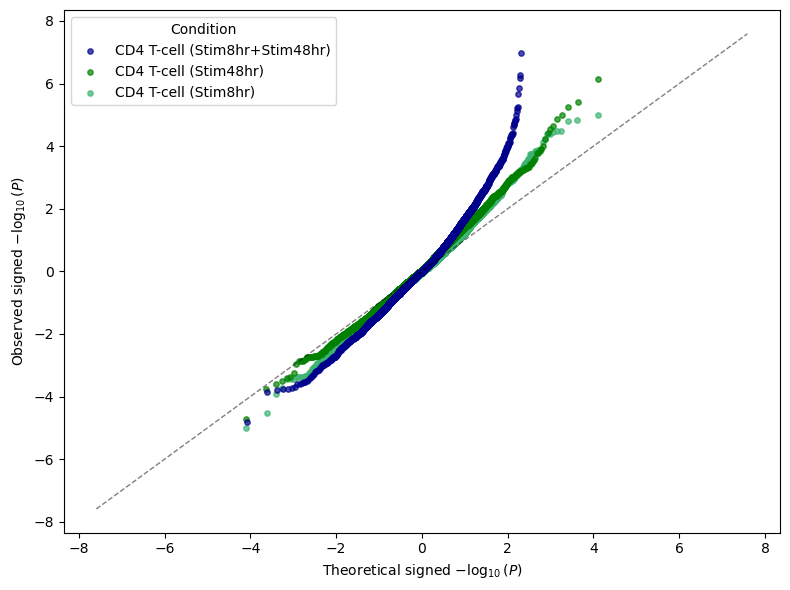

In [41]:
# QQ plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

outputs = single_outputs | pair_outputs
# conds = ["Rest", "Stim8hr", "Stim48hr", "Rest+Stim8hr", "Rest+Stim48hr", "Stim8hr+Stim48hr"]
# base_color_map = {"Rest": "lightgreen", "Stim8hr": "mediumseagreen", "Stim48hr": "green", "Rest+Stim8hr": "lightblue", "Rest+Stim48hr": "steelblue", "Stim8hr+Stim48hr": "darkblue"}
conds = ["Stim8hr", "Stim48hr", "Stim8hr+Stim48hr"]
base_color_map = {"Stim8hr": "mediumseagreen", "Stim48hr": "green", "Stim8hr+Stim48hr": "darkblue"}

for cond in conds:
    df = outputs[cond]
    
    n_rows = len(df)
    print(f"{cond}: {n_rows} unique genes")
    
    ax, top_genes = qq_signed_logp(
        df["p_beta"].values,
        df["beta"].values,
        ax,
        label=cond,
        genes=df["gene"].values,
        top_n=0,  # No top genes
        gene_set=None,  # No gene set
        gene_set_color=None,
        base_color=base_color_map[cond]  
    )

# Format the plot
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]),
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

ax.plot([-lim, lim], [-lim, lim], color="black", lw=1, linestyle='--', alpha=0.5)
ax.set_xlabel("Theoretical signed $-\\log_{10}(P)$")
ax.set_ylabel("Observed signed $-\\log_{10}(P)$")
# ax.set_title("QQ‐plot of signed $-\\log_{10}(P)$ by condition")

custom_labels = []
for cond in conds:
    if cond.startswith("Stim") or cond.startswith("Rest"):
        custom_labels.append(f"CD4 T-cell ({cond})")
    else:
        custom_labels.append(cond)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], custom_labels[::-1], title="Condition")

plt.tight_layout()
plt.show()

In [42]:
# top genes
outputs['Stim8hr+Stim48hr'].sort_values(by='p_beta', ascending=True).head(20)

,gene,ensg,n,k,R2,beta,p_beta
0,ITGAM,ENSG00000169896,10647,3,0.013434,0.060533,1.025190e-07
1,CTSC,ENSG00000109861,10647,3,0.013192,0.059234,5.403809e-07
2,TBC1D1,ENSG00000065882,10647,3,0.013237,0.059429,6.910739e-07
3,CAPZA1,ENSG00000116489,10647,3,0.013040,0.061501,1.344500e-06
4,SAMD3,ENSG00000164483,10647,3,0.012968,0.052088,2.126564e-06
5,GLIPR2,ENSG00000122694,10647,3,0.012871,0.052301,5.739972e-06
6,IL18R1,ENSG00000115604,10647,3,0.013076,0.052958,6.048965e-06
7,CD47,ENSG00000196776,10647,3,0.012661,0.056026,7.399777e-06
8,ARHGAP25,ENSG00000163219,10647,3,0.012618,0.053281,1.017616e-05
9,BIVM,ENSG00000134897,10647,3,0.012702,0.053372,1.332192e-05


### Negative control with K562 + Stim8hr/48hr

In [43]:
# negative control with K562
k562_pert_file = "/mnt/oak/users/mineto/workstation/K562_manuscript_upload/data/Perturbseq/geneLevel/limma_logFC_sum.txt"
k562_pert = pd.read_csv(k562_pert_file, sep="\t", header=0)
k562_pert.set_index("GENE", inplace=True)
cond_mats['K562'] = k562_pert

In [44]:
# if symbols, map to ENSG
if not pd.Index(betas.index).astype(str).str.startswith("ENSG").all():
    mapped = pd.Index(betas.index).to_series().map(sym2ensg)
    ok = mapped.notna()
    betas = betas.loc[ok, :]
    betas.index = mapped[ok].values

# optional: keep only genes present in LOF to reduce work
keep = betas.index.intersection(lof["ensg"].unique())
if len(keep) > 0:
    betas = betas.loc[keep, :]

shet = load_shet(shet_file, keep_ensg=set(lof["ensg"]))
os.makedirs(out_dir, exist_ok=True)

conditions_single = ["K562", "Stim8hr", "Stim48hr"]
conditions_pair   = [("K562", "Stim8hr"),
                     ("K562", "Stim48hr")]

from collections import Counter

single_outputs = {}
base = os.path.basename(burden_file)
for cond in tqdm(conditions_single, desc="Single-condition sets", leave=False):
    out_path = os.path.join(out_dir, f"{cond}_{base}_geneRegulation_correlation.txt")
    if os.path.exists(out_path):
        out = pd.read_csv(out_path, sep="\t")
        single_outputs[cond] = out
        print(f"[{cond}] loaded {len(out)} models from {out_path}")
        continue

    df_cond = cond_mats[cond]
    rows = []
    skip = Counter()

    for resp_ensg in tqdm(df_cond.index, desc=f"{cond}: genes", leave=False):
        tmp = pd.DataFrame({
            "target_symbol": df_cond.columns,
            "perturb_beta": df_cond.loc[resp_ensg, :].values
        })
        tmp["ensg"] = tmp["target_symbol"].map(sym2ensg)
        tmp = tmp.dropna(subset=["ensg"])
        tmp = tmp[tmp["ensg"] != resp_ensg]

        df2 = tmp.merge(lof, on="ensg", how="inner")
        if shet is not None:
            df2 = df2.merge(shet, on="ensg", how="inner")

        if df2.shape[0] <= min_targets:
            skip["too_few_targets"] += 1
            continue

        y = pd.to_numeric(df2["post_mean"], errors="coerce")
        x1 = zscore_series(df2["perturb_beta"])
        y_z = zscore_series(y)

        if x1 is None or y_z is None:
            skip["constant_or_nan_predictor"] += 1
            continue

        X = pd.DataFrame({"perturb_beta": x1})
        if shet is not None and "shet" in df2:
            X["shet"] = pd.to_numeric(df2["shet"], errors="coerce")

        X = sm.add_constant(X, has_constant="add")
        try:
            res = sm.OLS(y_z, X, missing="drop").fit()
        except Exception:
            skip["model_fit_error"] += 1
            continue

        beta = float(res.params.get("perturb_beta", np.nan))
        p_beta = float(res.pvalues.get("perturb_beta", np.nan))
        rows.append({
            "gene": ensg2sym.get(resp_ensg, resp_ensg),
            "ensg": resp_ensg,
            "n": int(res.nobs),
            "k": int(X.shape[1] - 1),
            "R2": float(res.rsquared) if res.rsquared is not None else np.nan,
            "beta": beta,
            "p_beta": p_beta
        })

    out = pd.DataFrame(rows)
    if out.empty:
        out = pd.DataFrame(columns=["gene", "ensg", "n", "k", "R2", "beta", "p_beta"])
        print(f"[{cond}] no models met criteria. Skips: {dict(skip)}")
    else:
        out = out.sort_values(by="p_beta", na_position="last").reset_index(drop=True)
        print(f"[{cond}] fitted {len(out)} models. Skips: {dict(skip)}")

    single_outputs[cond] = out
    out.to_csv(out_path, sep="\t", index=False)
    print(f"[{cond}] saved {len(out)} models to {out_path}")

Single-condition sets:   0%|          | 0/3 [00:00<?, ?it/s]

[K562] loaded 8248 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/K562_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Stim8hr] loaded 12497 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Stim8hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[Stim48hr] loaded 12739 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt


In [45]:
pair_outputs = {}

for condA, condB in tqdm(conditions_pair, desc="Pair-condition sets", leave=False):
    tag = f"{condA}+{condB}"
    out_path = os.path.join(out_dir, f"{tag}_{base}_geneRegulation_correlation.txt")

    # load if cached
    if os.path.exists(out_path):
        out = pd.read_csv(out_path, sep="\t")
        pair_outputs[tag] = out
        print(f"[{tag}] loaded {len(out)} models from {out_path}")
        continue

    dfA2, dfB2 = build_pair_design(cond_mats[condA], cond_mats[condB])
    common_resp = dfA2.index.intersection(dfB2.index)
    dfA2 = dfA2.loc[common_resp, :]
    dfB2 = dfB2.loc[common_resp, :]

    rows = []
    skip = Counter()

    for resp_ensg in tqdm(dfA2.index, desc=f"{tag}: genes", leave=False):
        tmp = pd.DataFrame({
            "target_symbol": dfA2.columns,
            "perturb_beta_cond1": dfA2.loc[resp_ensg, :].values,
            "perturb_beta_cond2": dfB2.loc[resp_ensg, :].values
        })
        tmp["ensg"] = tmp["target_symbol"].map(sym2ensg)
        tmp = tmp.dropna(subset=["ensg"])
        tmp = tmp[tmp["ensg"] != resp_ensg]

        df2 = tmp.merge(lof, on="ensg", how="inner")
        if shet is not None:
            df2 = df2.merge(shet, on="ensg", how="inner")

        if df2.shape[0] <= min_targets:
            skip["too_few_targets"] += 1
            continue

        y  = pd.to_numeric(df2["post_mean"], errors="coerce")
        x1 = zscore_series(df2["perturb_beta_cond1"])
        x2 = zscore_series(df2["perturb_beta_cond2"])
        y_z = zscore_series(y)

        if x1 is None or x2 is None or y_z is None:
            skip["constant_or_nan_predictor"] += 1
            continue

        X = pd.DataFrame({
            "perturb_beta_cond1": x1,
            "perturb_beta_cond2": x2
        })
        if shet is not None and "shet" in df2:
            svec = pd.to_numeric(df2["shet"], errors="coerce")
            if svec.nunique(dropna=True) > 1:
                X["shet"] = svec
            else:
                skip["shet_constant_dropped"] += 1

        X = sm.add_constant(X, has_constant="add")

        try:
            res = sm.OLS(y_z, X, missing="drop").fit()
        except Exception:
            skip["model_fit_error"] += 1
            continue

        beta_c1 = float(res.params.get("perturb_beta_cond1", np.nan))
        beta_c2 = float(res.params.get("perturb_beta_cond2", np.nan))
        beta_sum = (beta_c1 + beta_c2) if np.isfinite(beta_c1) and np.isfinite(beta_c2) else np.nan

        V = res.cov_params()
        if {"perturb_beta_cond1", "perturb_beta_cond2"}.issubset(V.index):
            v11 = float(V.loc["perturb_beta_cond1", "perturb_beta_cond1"])
            v22 = float(V.loc["perturb_beta_cond2", "perturb_beta_cond2"])
            v12 = float(V.loc["perturb_beta_cond1", "perturb_beta_cond2"])
            var_sum = v11 + v22 + 2.0 * v12
            if np.isfinite(var_sum) and var_sum < 0 and var_sum > -1e-12:
                var_sum = 0.0
            se_sum = float(np.sqrt(var_sum)) if (np.isfinite(var_sum) and var_sum >= 0) else np.nan
        else:
            se_sum = np.nan

        if np.isfinite(beta_sum) and np.isfinite(se_sum) and se_sum > 0 and np.isfinite(res.df_resid) and res.df_resid > 0:
            t_sum = beta_sum / se_sum
            p_sum = float(2 * stats.t.sf(abs(t_sum), df=int(res.df_resid)))
        else:
            p_sum = np.nan

        rows.append({
            "gene": ensg2sym.get(resp_ensg, resp_ensg),
            "ensg": resp_ensg,
            "n": int(res.nobs),
            "k": int(X.shape[1] - 1),
            "R2": float(res.rsquared) if res.rsquared is not None else np.nan,
            "beta": float(beta_sum),
            "p_beta": float(p_sum)
        })

    out = pd.DataFrame(rows)
    if out.empty:
        out = pd.DataFrame(columns=["gene", "ensg", "n", "k", "R2", "beta", "p_beta"])
        print(f"[{tag}] no models met criteria. Skips: {dict(skip)}")
    else:
        out = out.sort_values(by="p_beta", na_position="last").reset_index(drop=True)
        print(f"[{tag}] fitted {len(out)} models. Skips: {dict(skip)}")

    pair_outputs[tag] = out
    out.to_csv(out_path, sep="\t", index=False)
    print(f"[{tag}] saved {len(out)} models to {out_path}")

Pair-condition sets:   0%|          | 0/2 [00:00<?, ?it/s]

[K562+Stim8hr] loaded 7017 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/K562+Stim8hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt
[K562+Stim48hr] loaded 7017 models from /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/K562+Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt


K562: 8248 unique genes
Stim8hr: 12497 unique genes
Stim48hr: 12739 unique genes
K562+Stim8hr: 7017 unique genes
K562+Stim48hr: 7017 unique genes


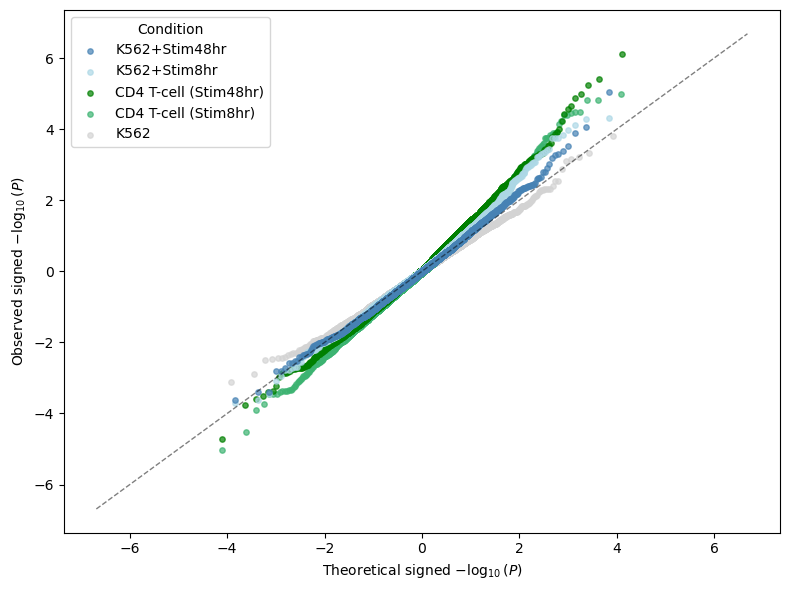

In [46]:
# QQ plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

outputs = single_outputs | pair_outputs
# conds = ["Rest", "Stim8hr", "Stim48hr", "Rest+Stim8hr", "Rest+Stim48hr", "Stim8hr+Stim48hr"]
# base_color_map = {"Rest": "lightgreen", "Stim8hr": "mediumseagreen", "Stim48hr": "green", "Rest+Stim8hr": "lightblue", "Rest+Stim48hr": "steelblue", "Stim8hr+Stim48hr": "darkblue"}
conds = ["K562", "Stim8hr", "Stim48hr", "K562+Stim8hr", "K562+Stim48hr"]
base_color_map = {"K562": "lightgray", "Stim8hr": "mediumseagreen", "Stim48hr": "green", "K562+Stim8hr": "lightblue", "K562+Stim48hr": "steelblue"}

for cond in conds:
    df = outputs[cond]
    
    n_rows = len(df)
    print(f"{cond}: {n_rows} unique genes")
    
    ax, top_genes = qq_signed_logp(
        df["p_beta"].values,
        df["beta"].values,
        ax,
        label=cond,
        genes=df["gene"].values,
        top_n=0,  # No top genes
        gene_set=None,  # No gene set
        gene_set_color=None,
        base_color=base_color_map[cond]  
    )

# Format the plot
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]),
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

ax.plot([-lim, lim], [-lim, lim], color="black", lw=1, linestyle='--', alpha=0.5)
# ax.plot([-5, 5], [-7.5, 7.5], color="black", lw=1, linestyle='--', alpha=0.5)
ax.set_xlabel("Theoretical signed $-\\log_{10}(P)$")
ax.set_ylabel("Observed signed $-\\log_{10}(P)$")
# ax.set_title("QQ‐plot of signed $-\\log_{10}(P)$ by condition")

custom_labels = []
for cond in conds:
    if cond.startswith("Stim") or cond.startswith("Rest"):
        custom_labels.append(f"CD4 T-cell ({cond})")
    else:
        custom_labels.append(cond)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], custom_labels[::-1], title="Condition")

plt.tight_layout()
plt.show()

### Testing calibration under the null

First, save data prior to running the analyses. 

In [47]:
# see what conditions we are saving
cond_mats.keys()

dict_keys(['Rest', 'Stim8hr', 'Stim48hr', 'K562'])

In [48]:
# # save files to call using freedman_lane_permutation.py
# import pickle

# outdir = "/mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/lymph"
# !mkdir -p $outdir

# # cond_mats
# with open(os.path.join(outdir, "cond_mats.pkl"), "wb") as f:
#     pickle.dump(cond_mats, f)

# # ensg2sym
# with open(os.path.join(outdir, "ensg2sym.pkl"), "wb") as f:
#     pickle.dump(ensg2sym, f)

# # sym2ensg
# with open(os.path.join(outdir, "sym2ensg.pkl"), "wb") as f:
#     pickle.dump(sym2ensg, f)

# # lof
# lof.to_csv(os.path.join(outdir, "lof.tsv"), sep="\t", index=False)

# # shet
# shet.to_csv(os.path.join(outdir, "shet.tsv"), sep="\t", index=False)

#### Freedman-Lane residual permutation
Uses Freedman-Lane residual permutation to test if the distribution of signed -log10P values are calibrated under the null. 

Goal: preserve the joint structure of $s_{het}$ with burden effect and with regulator effect.

1.	Fit the reduced model without $\text{Regulator effect}$:
$$\text{Burden effect} = s_{het}\alpha + r, \quad \hat r = \text{Burden effect} - s_{het}\hat\alpha.$$
2.	For each permutation $\pi$, permute the residuals $\hat r$ across samples: $\hat r^{(\pi)} = P_\pi \hat r$.
3.	Construct a permuted response that keeps $s_{het}$ fixed:
$$\text{Burden effect}^{(\pi)} = s_{het}\hat\alpha + \hat r^{(\pi)}.$$
4.	Fit the full model on ($\text{Burden effect}^{(\pi)}$, $\text{Regulator effect}$, $s_{het}$) and extract the test statistic for $\text{Regulator effect}$.

This yields a valid null even when $\text{Regulator effect}$ and $s_{het}$ are correlated, and it preserves the cothe rrelation/dependence structure of $\text{Burden effect}$.

In [49]:
# After running freedman_lane_array.sh, show the results: 
freedman_lane_file = "/mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/lymph/permutation_results/freedman_lane_global_calibration.csv"
if os.path.exists(freedman_lane_file):
    fl_res = pd.read_csv(freedman_lane_file)
    print(fl_res)
else:
    print(f"File not found: {freedman_lane_file}")

               cond  KS_stat_observed  KS_global_p  lambda_GC_observed  \
0           Stim8hr          0.055263     0.034965            1.227853   
1          Stim48hr          0.095470     0.009990            1.438800   
2  Stim8hr+Stim48hr          0.121464     0.002997            1.596419   
3              K562          0.056267     0.012987            0.800301   
4      K562+Stim8hr          0.039905     0.042957            1.118330   
5     K562+Stim48hr          0.035414     0.092907            1.144487   

   lambda_GC_perm_median  lambda_GC_ratio  
0               0.962570         1.275599  
1               0.959352         1.499763  
2               0.962070         1.659359  
3               0.982039         0.814938  
4               0.985317         1.134996  
5               0.982422         1.164965  


#### Sign reversal
Uses a modified version of Freedman-Lane residual permutation to test if the distribution of signed -log10P values are calibrated under the null. This method randomly reverses the sign of the residual instead of permuting them across genes.

The goal remains the same: preserve the joint structure of $s_{het}$ with burden effect and with regulator effect.

1.	Fit the reduced model without $\text{Regulator effect}$:
$$\text{Burden effect} = s_{het}\alpha + r, \quad \hat r = \text{Burden effect} - s_{het}\hat\alpha.$$
2.	For each permutation $\pi$, permute the residuals $\hat r$ across samples: $\hat r^{(\pi)} = P_\pi \hat r$.
2. For each permutation￼$\pi$, randomly reverse the sign of residual $\hat r$: \hat r^{\pi}_i = s_i \hat r_i, where $s_i \sim \text{Bernoulli}(\tfrac{1}{2}$ independently takes values $\pm 1$. 
3.	Construct a permuted response that keeps $s_{het}$ fixed:
$$\text{Burden effect}^{(\pi)} = s_{het}\hat\alpha + \hat r^{(\pi)}.$$
4.	Fit the full model on ($\text{Burden effect}^{(\pi)}$, $\text{Regulator effect}$, $s_{het}$) and extract the test statistic for $\text{Regulator effect}$ for the QQ-plot.

This yields a valid null even when $\text{Regulator effect}$ and $s_{het}$ are correlated, and it preserves the correlation/dependence structure of $\text{Burden effect}$.

In [50]:
# After running sign_freedman_lane_array.sh, show the results: 
sign_fl_file = "/mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/lymph/sign_permutation_results/freedman_lane_global_calibration.csv"
if os.path.exists(sign_fl_file):
    sign_fl_res = pd.read_csv(sign_fl_file)
    print(sign_fl_res)
else:
    print(f"File not found: {sign_fl_file}")

File not found: /mnt/oak/users/rgoto/data/GWT_causal_gene_discovery/CD4i/burden_reg_corr/lymph/sign_permutation_results/freedman_lane_global_calibration.csv
